In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

import os, sys
import numpy as np
from syncological.results import load_exp, load_trial, sample_neurons
from syncological.results import trial_coding, power_coding, phase_coding
from syncological.results import extract_lfps, gamma_amplitude, peak_troughs
from fakespikes import neurons, util, rates
from scipy.stats import spearmanr

from collections import defaultdict
from random import shuffle

TEST = True

In [4]:
# -- Choose trials and neurons
data_path = os.getenv('IPY_DATA_PATH')
if TEST:
    data_path = "/home/ejp/src/syncological/data/exp500/"

if data_path is None:
    raise ValueError("The environmental variable IPY_DATA_PATH not found.")

print("Using data from {}".format(data_path))

# -
analysis_name = "trials"    
save_path = os.path.join(data_path, analysis_name)
try: 
    os.makedirs(save_path)
except OSError:
    if not os.path.isdir(save_path):
        raise
    
n_trials = 20
n_neurons = 10
offset = 0.1

Using data from /home/ejp/src/syncological/data/exp500/


In [5]:
# -- Sampling info
fs = int(np.round(1/1e-5))
dt = 1 / float(fs)
times = load_trial(1, 0, data_path, to_load=['exampletrace_e'])['exampletrace_e'][:, 0]
times = times[times > offset]
t_range = (times.min(), times.max())

In [6]:
# -- Get the data
to_load = [
    "spiketimes_e",
    "spiketimes_stim",
    "lfp",
    "exampletrace_e"
]

vis_1 = load_exp(1, n_trials, data_path, to_load, offset=offset)
vis_2 = load_exp(2, n_trials, data_path, to_load, offset=offset)
box_1 = load_exp(3, n_trials, data_path, to_load, offset=offset)
box_2 = load_exp(4, n_trials, data_path, to_load, offset=offset)

##  Consistency between trials.

Using the first trial as the reference.

In [ ]:
vis_precs, vis_lev_s, vis_lev_o, vis_lev_r = trial_coding(vis_1)
box_precs, box_lev_s, box_lev_o, box_lev_r = trial_coding(box_1)

# -
np.savetxt(os.path.join(save_path, "vis_trials.csv"),
            np.vstack([vis_precs, vis_lev_s, vis_lev_o, vis_lev_r]).transpose(),
            header="prev,spike,order,rate",
            delimiter=",",
            fmt='%.6f'
          )

np.savetxt(os.path.join(save_path, "box_trials.csv"),
            np.vstack([box_precs, box_lev_s, box_lev_o, box_lev_r]).transpose(),
            header="prev,spike,order,rate",
            delimiter=",",
            fmt='%.6f'
          )

### Visual stimulus

In [ ]:
# plot
plt.figure(figsize=(4, 16))

plt.subplot(411)
plt.hist((vis_precs * 1000), bins=10, color='k');
plt.xlabel("Spike precision (ms)")
sns.despine()

plt.subplot(412)
plt.hist(vis_lev_s, bins=10, color='k');
plt.axvline(x=1, color='k', linewidth=1, linestyle='--')
plt.xlim(0, 1.1)
plt.xlabel("Spike fidelity")
sns.despine()

plt.subplot(413)
plt.hist(vis_lev_o, bins=10, color='k');
plt.axvline(x=1, color='k', linewidth=1, linestyle='--')
plt.xlim(0, 1.1)
plt.xlabel("Order fidelity")
sns.despine()

plt.subplot(414)
plt.hist(vis_lev_r, bins=10, color='k');
plt.axvline(x=1, color='k', linewidth=1, linestyle='--')
plt.xlim(0, 1.1)
plt.xlabel("Rate fidelity")
sns.despine()

### Boxcar stimulus

In [ ]:
# plot
plt.figure(figsize=(4, 16))

plt.subplot(411)
plt.hist((box_precs * 1000), bins=10, color='k');
plt.xlabel("Spike precision (ms)")
sns.despine()

plt.subplot(412)
plt.hist(box_lev_s, bins=10, color='k');
plt.axvline(x=1, color='k', linewidth=1, linestyle='--')
plt.xlim(0, 1.1)
plt.xlabel("Spike fidelity")
sns.despine()

plt.subplot(413)
plt.hist(box_lev_o, bins=10, color='k');
plt.axvline(x=1, color='k', linewidth=1, linestyle='--')
plt.xlim(0, 1.1)
plt.xlabel("Order fidelity")
sns.despine()

plt.subplot(414)
plt.hist(box_lev_r, bins=10, color='k');
plt.axvline(x=1, color='k', linewidth=1, linestyle='--')
plt.xlim(0, 1.1)
plt.xlabel("Rate fidelity")
sns.despine()

## LFP decomposition

In [7]:
# - 
# Get, examine, and process LFP
vis_lfps = extract_lfps(vis_1)
vis_amps = gamma_amplitude(vis_lfps, fs)
vis_peaks, vis_troughs = peak_troughs(vis_lfps, fs)

box_lfps = extract_lfps(box_1)
box_amps = gamma_amplitude(box_lfps, fs)
box_peaks, box_troughs = peak_troughs(box_lfps, fs)

# save
np.save(os.path.join(save_path, "vis_lfp.npy"), vis_lfps)
np.save(os.path.join(save_path, "vis_amp.npy"), vis_amps)
np.save(os.path.join(save_path, "vis_peaks.npy"), vis_peaks)
np.save(os.path.join(save_path, "vis_troughs.npy"), vis_troughs)

np.save(os.path.join(save_path, "box_lfp.npy"), box_lfps)
np.save(os.path.join(save_path, "box_amp.npy"), box_amps)
np.save(os.path.join(save_path, "box_peaks.npy"), box_peaks)
np.save(os.path.join(save_path, "box_troughs.npy"), box_troughs)

### Visual stimulus

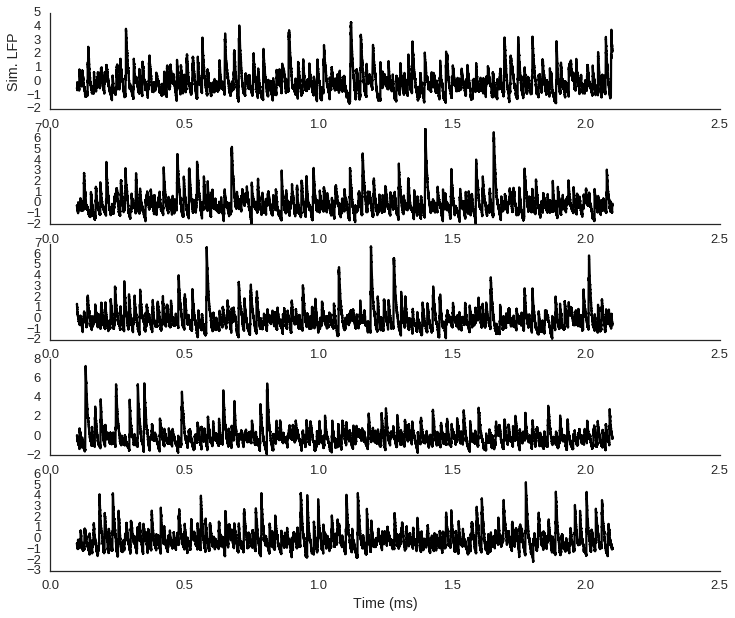

In [8]:
# - plot 
# the first five as examples
plt.figure(figsize=(12, 10))
for i, lfp in enumerate(vis_lfps[:5]):
    plt.subplot(len(vis_lfps[:5]), 1, i + 1)
    plt.plot(times/1000e-3, lfp, color='k', label=i)
    if i == 0:
        plt.ylabel("Sim. LFP")
    sns.despine()
plt.xlabel("Time (ms)")

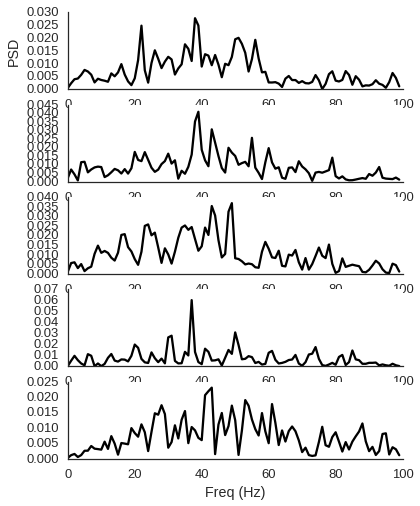

In [9]:
# - psd
plt.figure(figsize=(6, 8))
# plot five examples
for i, lfp in enumerate(vis_lfps[:5]):
    freqs, spec = util.create_psd(lfp, fs)
    
    plt.subplot(len(vis_lfps[:5]), 1, i + 1)
    plt.plot(freqs[freqs < 100], spec[freqs < 100], color='k')
    if i == 0:
        plt.ylabel("PSD")
    sns.despine()
    
plt.xlabel("Freq (Hz)") 

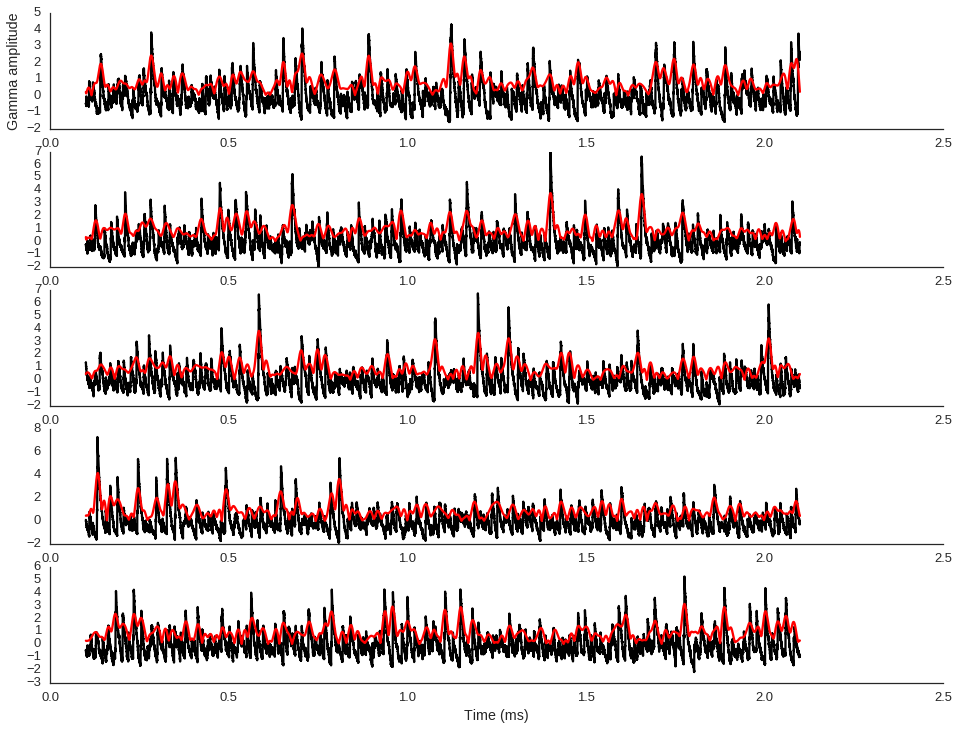

In [10]:
plt.figure(figsize=(16, 12))
for i, (amp, lfp) in enumerate(zip(vis_amps[:5], vis_lfps[:5])):
    plt.subplot(len(vis_amps[:5]), 1, i + 1)
    plt.plot(times/1000e-3, lfp, color='k', label=i)
    plt.plot(times/1000e-3, amp, color='r', label=i)
    
    if i == 0:
        plt.ylabel("Gamma amplitude")
    
    sns.despine()
    
plt.xlabel("Time (ms)")

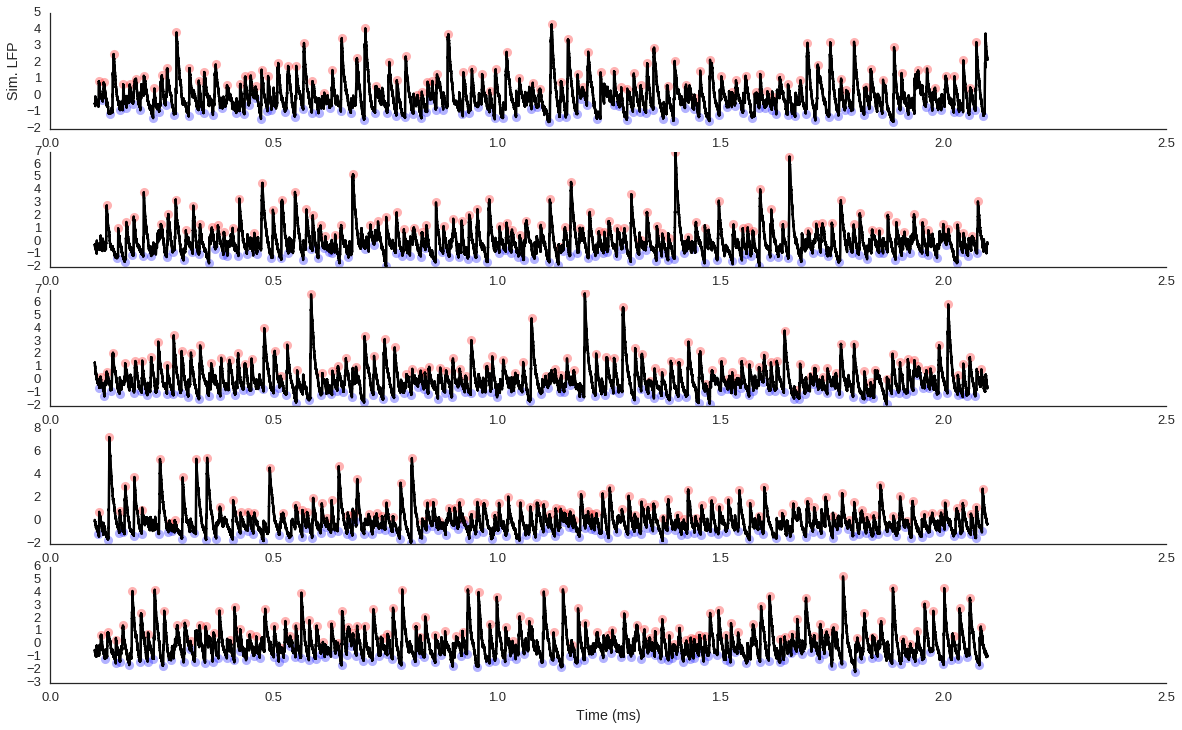

In [11]:
plt.figure(figsize=(20, 12))
i = 0
for lfp, pk, tr in zip(vis_lfps[:5], vis_peaks[:5], vis_troughs[:5]):
    plt.subplot(len(vis_lfps[:5]), 1, i + 1)
    plt.plot(times/1000e-3, lfp, color='k', label=i)
    plt.plot(times[pk], lfp[pk], 'ro', alpha=0.3)
    plt.plot(times[tr], lfp[tr], 'bo', alpha=0.3)
    plt.plot(times, lfp, color='k', label=i)
    sns.despine()
    
    if i == 0:
        plt.ylabel("Sim. LFP")
        
    i += 1 
    
plt.xlabel("Time (ms)")

### Boxcar stimulus

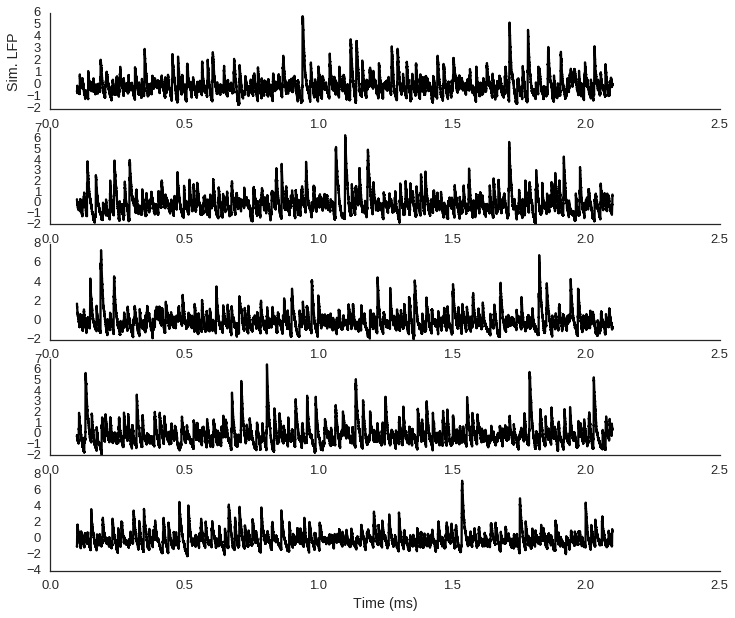

In [12]:
# - plot 
# the first five as examples
plt.figure(figsize=(12, 10))
for i, lfp in enumerate(box_lfps[:5]):
    plt.subplot(len(box_lfps[:5]), 1, i + 1)
    plt.plot(times/1000e-3, lfp, color='k', label=i)
    if i == 0:
        plt.ylabel("Sim. LFP")
    sns.despine()
plt.xlabel("Time (ms)")

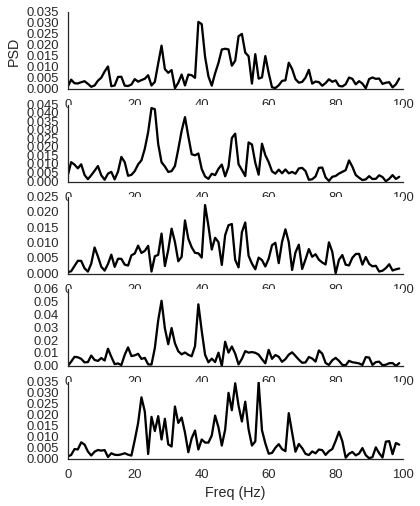

In [13]:
# - psd
plt.figure(figsize=(6, 8))
# plot five examples
for i, lfp in enumerate(box_lfps[:5]):
    freqs, spec = util.create_psd(lfp, fs)
    
    plt.subplot(len(box_lfps[:5]), 1, i + 1)
    plt.plot(freqs[freqs < 100], spec[freqs < 100], color='k')
    if i == 0:
        plt.ylabel("PSD")
    sns.despine()
    
plt.xlabel("Freq (Hz)") 

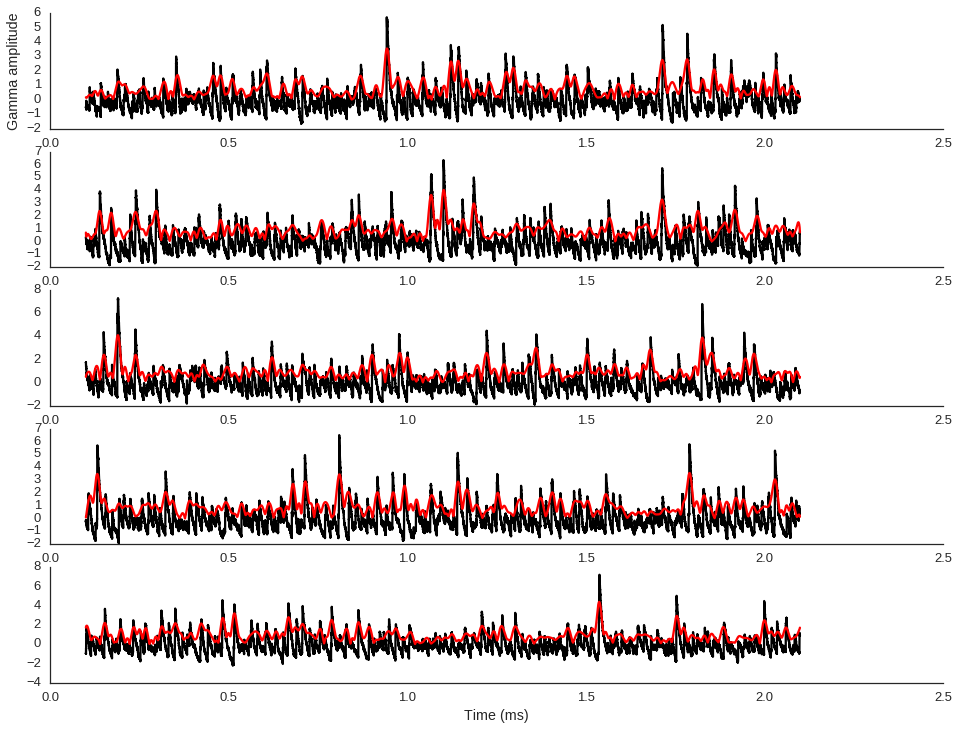

In [14]:
plt.figure(figsize=(16, 12))
for i, (amp, lfp) in enumerate(zip(box_amps[:5], box_lfps[:5])):
    plt.subplot(len(box_amps[:5]), 1, i + 1)
    plt.plot(times/1000e-3, lfp, color='k', label=i)
    plt.plot(times/1000e-3, amp, color='r', label=i)
    
    if i == 0:
        plt.ylabel("Gamma amplitude")
    
    sns.despine()
    
plt.xlabel("Time (ms)")

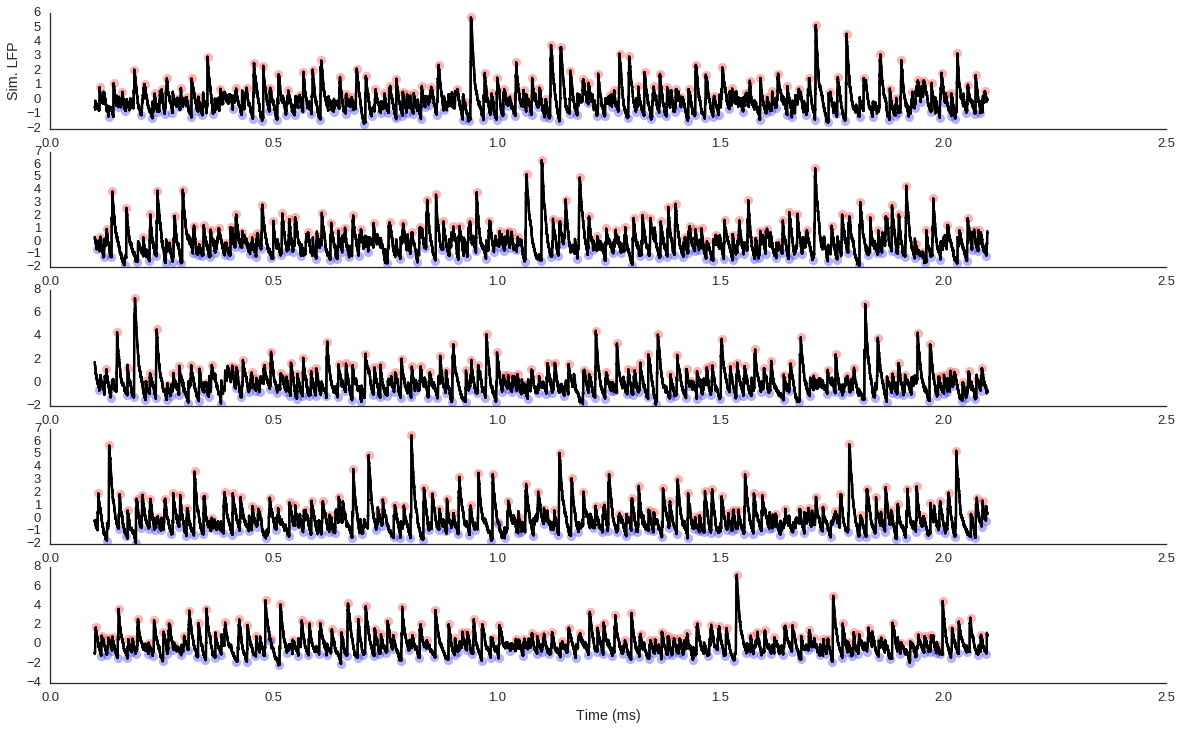

In [15]:
plt.figure(figsize=(20, 12))
i = 0
for lfp, pk, tr in zip(box_lfps[:5], box_peaks[:5], box_troughs[:5]):
    plt.subplot(len(box_lfps[:5]), 1, i + 1)
    plt.plot(times/1000e-3, lfp, color='k', label=i)
    plt.plot(times[pk], lfp[pk], 'ro', alpha=0.3)
    plt.plot(times[tr], lfp[tr], 'bo', alpha=0.3)
    plt.plot(times, lfp, color='k', label=i)
    sns.despine()
    
    if i == 0:
        plt.ylabel("Sim. LFP")
        
    i += 1 
    
plt.xlabel("Time (ms)")

# Coding and gamma power

In [16]:
vis_precs, vis_lev_s, vis_lev_o, vis_lev_r, vis_pows, vis_trials, skip_i, skip_r = power_coding(
    vis_1, times, vis_lfps, vis_amps, vis_peaks
)

box_precs, box_lev_s, box_lev_o, box_lev_r, box_pows, box_trials, skip_i, skip_r = power_coding(
    box_1, times, box_lfps, box_amps, box_peaks
)

# -
np.savetxt(os.path.join(save_path, "vis_pow.csv"),
            np.vstack([vis_trials, vis_pows, vis_precs, vis_lev_s, vis_lev_o, vis_lev_r]).transpose(),
            header="trials,amp,prec,spike,order,rate",
            delimiter=",",
            fmt='%.6f'
          )
np.savetxt(os.path.join(save_path, "box_pow.csv"),
            np.vstack([box_trials, box_pows, box_precs, box_lev_s, box_lev_o, box_lev_r]).transpose(),
            header="trials,amp,prec,spike,order,rate",
            delimiter=",",
            fmt='%.6f'
          )

### Visual stimulus

corr(pow, precision)
SpearmanrResult(correlation=0.247273836727155, pvalue=3.3326181438955999e-29)
corr(pow, spike fidelity)
SpearmanrResult(correlation=-0.012494584505070178, pvalue=0.57682543406383591)
corr(pow, rate fidelity)
SpearmanrResult(correlation=-0.045249369065472583, pvalue=0.04319034612699605)
corr(pow, precision)
SpearmanrResult(correlation=0.247273836727155, pvalue=3.3326181438955999e-29)


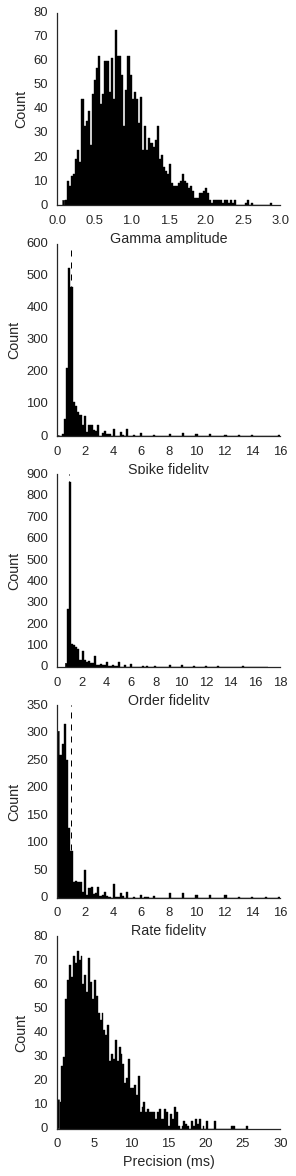

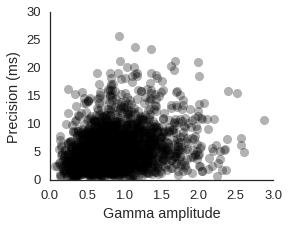

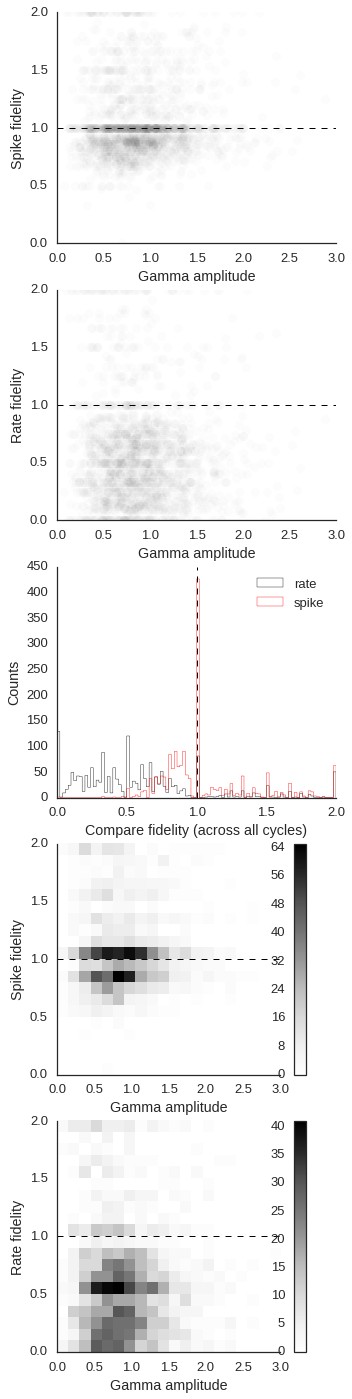

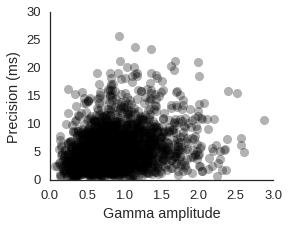

In [17]:
# plot raw values, getting a sense of the data
plt.figure(figsize=(4, 20))
plt.subplot(511)
plt.hist(vis_pows, color='k', bins=100);
plt.xlabel("Gamma amplitude")
plt.ylabel("Count")
sns.despine()

plt.subplot(512)
plt.hist(vis_lev_s, color='k', bins=100);
plt.axvline(x=1, color='k', linewidth=1, linestyle='--')
plt.xlabel("Spike fidelity")
plt.ylabel("Count")
sns.despine()

plt.subplot(513)
plt.hist(vis_lev_o, color='k', bins=100);
plt.axvline(x=1, color='k', linewidth=1, linestyle='--')
plt.xlabel("Order fidelity")
plt.ylabel("Count")
sns.despine()

plt.subplot(514)
plt.hist(vis_lev_r, color='k', bins=100);
plt.axvline(x=1, color='k', linewidth=1, linestyle='--')
plt.xlabel("Rate fidelity")
plt.ylabel("Count")
sns.despine()

plt.subplot(515)
plt.hist(vis_precs * 1000, color='k', bins=100);
plt.xlabel("Precision (ms)")
plt.ylabel("Count")
sns.despine()

# Plot measures by gamma amplitude
plt.figure(figsize=(4, 3))
plt.plot(vis_pows, vis_precs * 1000, 'ok', alpha=0.3)
plt.xlabel("Gamma amplitude")
plt.ylabel("Precision (ms)")
sns.despine()

print("corr(pow, precision)")
print(spearmanr(vis_pows, vis_precs))

plt.figure(figsize=(5, 24))
plt.subplot(511)
plt.plot(vis_pows, vis_lev_s, 'ok', alpha=0.01)
plt.axhline(y=1, color='k', linewidth=1, linestyle='--')
plt.xlabel("Gamma amplitude")
plt.ylabel("Spike fidelity")
plt.ylim(0, 2)
sns.despine()
print("corr(pow, spike fidelity)")
print(spearmanr(vis_pows, vis_lev_s))

plt.subplot(512)
plt.plot(vis_pows, vis_lev_r, 'ok', alpha=0.01)
plt.axhline(y=1, color='k', linewidth=1, linestyle='--')
plt.ylim(0, 2)
plt.xlabel("Gamma amplitude")
plt.ylabel("Rate fidelity")
sns.despine()
print("corr(pow, rate fidelity)")
print(spearmanr(vis_pows, vis_lev_r))

plt.subplot(513)
plt.hist(vis_lev_r, color='k', label='rate', bins=100, 
         range=(0, 2), histtype='step');
plt.hist(vis_lev_s, color='r', label='spike', bins=100, 
         range=(0, 2), histtype='step');
plt.axvline(x=1, color='k', linewidth=1, linestyle='--')
plt.xlabel("Compare fidelity (across all cycles)")
plt.ylabel("Counts")
plt.legend()
sns.despine()

plt.subplot(514)
_ = plt.hist2d(vis_pows, vis_lev_s, bins=20, range=[(0, 3.), (0. ,2.)])
plt.axhline(y=1, color='k', linewidth=1, linestyle='--')
plt.xlabel("Gamma amplitude")
plt.ylabel("Spike fidelity")
plt.colorbar()
sns.despine()

plt.subplot(515)
_ = plt.hist2d(vis_pows, vis_lev_r, bins=20, range=[(0, 3.), (0. ,2.)])
plt.axhline(y=1, color='k', linewidth=1, linestyle='--')
plt.colorbar()
plt.xlabel("Gamma amplitude")
plt.ylabel("Rate fidelity")
sns.despine()

# Plot measures by gamma amplitude
plt.figure(figsize=(4, 3))
plt.plot(vis_pows, vis_precs * 1000, 'ok', alpha=0.3)
plt.xlabel("Gamma amplitude")
plt.ylabel("Precision (ms)")
sns.despine()
print("corr(pow, precision)")
print(spearmanr(vis_pows, vis_precs))

### Boxcar stimulus

corr(pow, precision)
SpearmanrResult(correlation=0.2289678651887512, pvalue=2.4806566086021629e-25)
corr(pow, spike fidelity)
SpearmanrResult(correlation=-0.01165382567003386, pvalue=0.6014621698560314)
corr(pow, rate fidelity)
SpearmanrResult(correlation=-0.075744520087814987, pvalue=0.00067515885870716476)
corr(pow, precision)
SpearmanrResult(correlation=0.2289678651887512, pvalue=2.4806566086021629e-25)


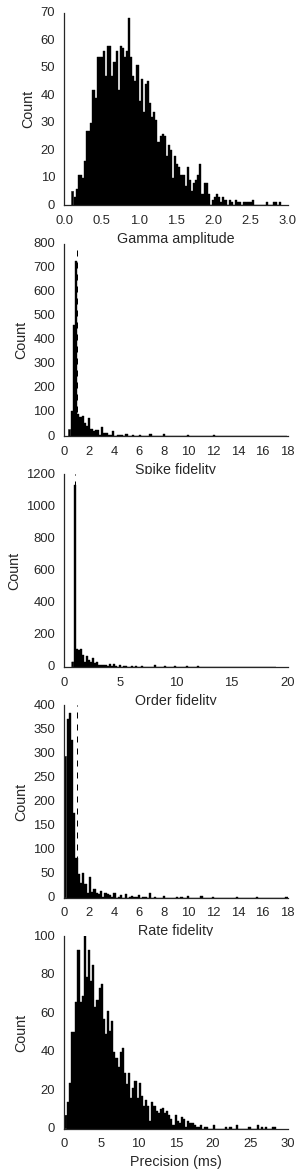

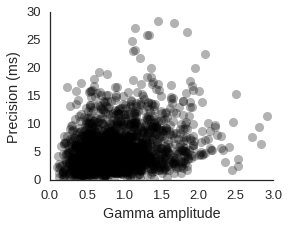

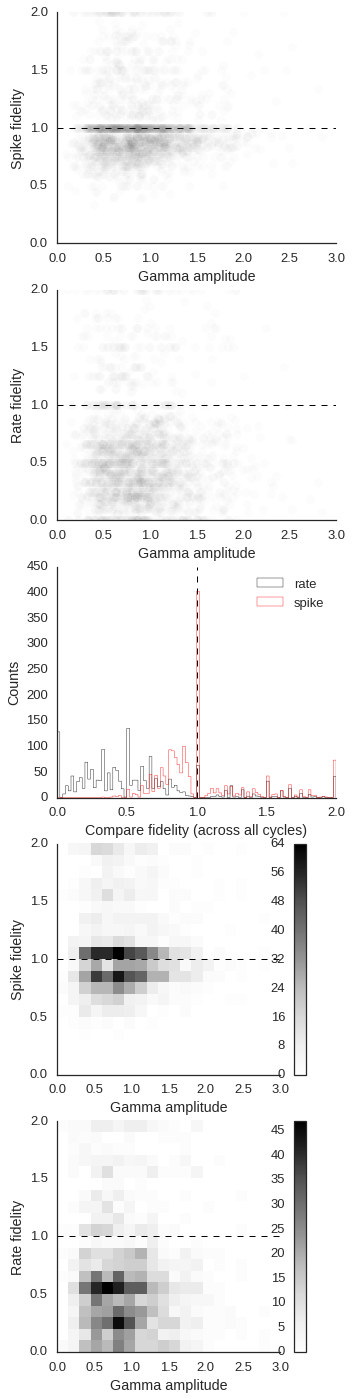

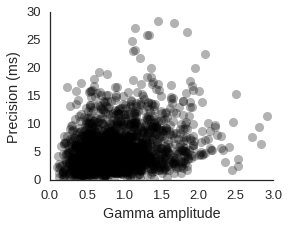

In [18]:
# plot raw values, getting a sense of the data
plt.figure(figsize=(4, 20))
plt.subplot(511)
plt.hist(box_pows, color='k', bins=100);
plt.xlabel("Gamma amplitude")
plt.ylabel("Count")
sns.despine()

plt.subplot(512)
plt.hist(box_lev_s, color='k', bins=100);
plt.axvline(x=1, color='k', linewidth=1, linestyle='--')
plt.xlabel("Spike fidelity")
plt.ylabel("Count")
sns.despine()

plt.subplot(513)
plt.hist(box_lev_o, color='k', bins=100);
plt.axvline(x=1, color='k', linewidth=1, linestyle='--')
plt.xlabel("Order fidelity")
plt.ylabel("Count")
sns.despine()

plt.subplot(514)
plt.hist(box_lev_r, color='k', bins=100);
plt.axvline(x=1, color='k', linewidth=1, linestyle='--')
plt.xlabel("Rate fidelity")
plt.ylabel("Count")
sns.despine()

plt.subplot(515)
plt.hist(box_precs * 1000, color='k', bins=100);
plt.xlabel("Precision (ms)")
plt.ylabel("Count")
sns.despine()

# Plot measures by gamma amplitude
plt.figure(figsize=(4, 3))
plt.plot(box_pows, box_precs * 1000, 'ok', alpha=0.3)
plt.xlabel("Gamma amplitude")
plt.ylabel("Precision (ms)")
sns.despine()

print("corr(pow, precision)")
print(spearmanr(box_pows, box_precs))

plt.figure(figsize=(5, 24))
plt.subplot(511)
plt.plot(box_pows, box_lev_s, 'ok', alpha=0.01)
plt.axhline(y=1, color='k', linewidth=1, linestyle='--')
plt.xlabel("Gamma amplitude")
plt.ylabel("Spike fidelity")
plt.ylim(0, 2)
sns.despine()
print("corr(pow, spike fidelity)")
print(spearmanr(box_pows, box_lev_s))

plt.subplot(512)
plt.plot(box_pows, box_lev_r, 'ok', alpha=0.01)
plt.axhline(y=1, color='k', linewidth=1, linestyle='--')
plt.ylim(0, 2)
plt.xlabel("Gamma amplitude")
plt.ylabel("Rate fidelity")
sns.despine()
print("corr(pow, rate fidelity)")
print(spearmanr(box_pows, box_lev_r))

plt.subplot(513)
plt.hist(box_lev_r, color='k', label='rate', bins=100, 
         range=(0, 2), histtype='step');
plt.hist(box_lev_s, color='r', label='spike', bins=100, 
         range=(0, 2), histtype='step');
plt.axvline(x=1, color='k', linewidth=1, linestyle='--')
plt.xlabel("Compare fidelity (across all cycles)")
plt.ylabel("Counts")
plt.legend()
sns.despine()

plt.subplot(514)
_ = plt.hist2d(box_pows, box_lev_s, bins=20, range=[(0, 3.), (0. ,2.)])
plt.axhline(y=1, color='k', linewidth=1, linestyle='--')
plt.xlabel("Gamma amplitude")
plt.ylabel("Spike fidelity")
plt.colorbar()
sns.despine()

plt.subplot(515)
_ = plt.hist2d(box_pows, box_lev_r, bins=20, range=[(0, 3.), (0. ,2.)])
plt.axhline(y=1, color='k', linewidth=1, linestyle='--')
plt.colorbar()
plt.xlabel("Gamma amplitude")
plt.ylabel("Rate fidelity")
sns.despine()

# Plot measures by gamma amplitude
plt.figure(figsize=(4, 3))
plt.plot(box_pows, box_precs * 1000, 'ok', alpha=0.3)
plt.xlabel("Gamma amplitude")
plt.ylabel("Precision (ms)")
sns.despine()
print("corr(pow, precision)")
print(spearmanr(box_pows, box_precs))

# Coding by gamma phase

In [19]:
(
    vis_precs_rise, vis_precs_fall, 
    vis_lev_s_rise, vis_lev_s_fall, 
    vis_lev_o_rise, vis_lev_o_fall, 
    vis_lev_r_rise, vis_lev_r_fall,
    vis_trials_k, skip_f, skip_r
) = phase_coding(vis_1, times, vis_peaks, vis_troughs)

(
    box_precs_rise, box_precs_fall, 
    box_lev_s_rise, box_lev_s_fall, 
    box_lev_o_rise, box_lev_o_fall, 
    box_lev_r_rise, box_lev_r_fall,
    box_trials_k, skip_f, skip_r
) = phase_coding(box_1, times, box_peaks, box_troughs)


# save
np.savetxt(os.path.join(save_path, "vis_rise.csv"),
            np.vstack([vis_trials_k, vis_precs_rise, vis_lev_s_rise,
                       vis_lev_o_rise, vis_lev_r_rise]).transpose(),
            header="trials,prec,spike,order,rate",
            delimiter=",",
            fmt='%.6f'
          )
np.savetxt(os.path.join(save_path, "vis_fall.csv"),
            np.vstack([vis_trials_k, vis_precs_fall, vis_lev_s_fall, 
                       vis_lev_o_fall, vis_lev_r_fall]).transpose(),
            header="trials,prec,spike,order,rate",
            delimiter=",",
            fmt='%.6f'
          )
np.savetxt(os.path.join(save_path, "box_rise.csv"),
            np.vstack([box_trials_k, box_precs_rise, box_lev_s_rise,
                       box_lev_o_rise, box_lev_r_rise]).transpose(),
            header="trials,prec,spike,order,rate",
            delimiter=",",
            fmt='%.6f'
          )
np.savetxt(os.path.join(save_path, "box_fall.csv"),
            np.vstack([box_trials_k, box_precs_fall, box_lev_s_fall, 
                       box_lev_o_fall, box_lev_r_fall]).transpose(),
            header="trials,prec,spike,order,rate",
            delimiter=",",
            fmt='%.6f'
          )

### Visual stimulus

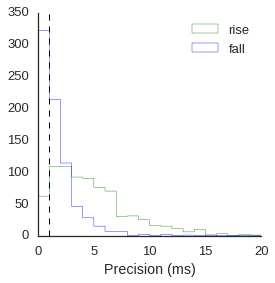

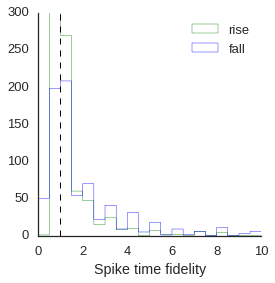

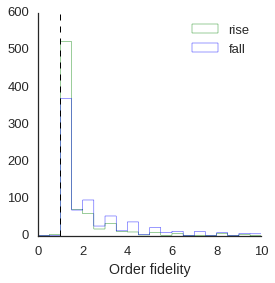

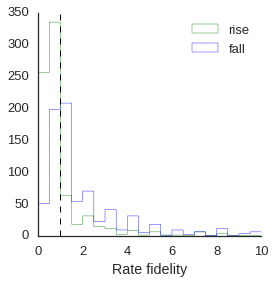

In [20]:
plt.figure(figsize=(4, 4))
plt.hist(vis_precs_rise * 1000, color='g', label='rise', bins=20, range=(0, 20), histtype='step');
plt.hist(vis_precs_fall * 1000, color='b', label='fall', bins=20, range=(0, 20), histtype='step');
plt.axvline(x=1, color='k', linewidth=1, linestyle='--')
plt.xlabel("Precision (ms)")
plt.legend()
sns.despine()

plt.figure(figsize=(4, 4))
plt.hist(vis_lev_s_rise, color='g', label='rise', bins=20, range=(0, 10), histtype='step');
plt.hist(vis_lev_s_fall, color='b', label='fall', bins=20, range=(0, 10), histtype='step');
plt.axvline(x=1, color='k', linewidth=1, linestyle='--')
plt.xlabel("Spike time fidelity")
plt.legend()
sns.despine()

plt.figure(figsize=(4, 4))
plt.hist(vis_lev_o_rise, color='g', label='rise', bins=20, range=(0, 10), histtype='step');
plt.hist(vis_lev_o_fall, color='b', label='fall', bins=20, range=(0, 10), histtype='step');
plt.axvline(x=1, color='k', linewidth=1, linestyle='--')
plt.xlabel("Order fidelity")
plt.legend()
sns.despine()

plt.figure(figsize=(4, 4))
plt.hist(vis_lev_r_rise, color='g', label='rise', bins=20, range=(0, 10), histtype='step');
plt.hist(vis_lev_r_fall, color='b', label='fall', bins=20, range=(0, 10), histtype='step');
plt.axvline(x=1, color='k', linewidth=1, linestyle='--')
plt.xlabel("Rate fidelity")
plt.legend()
sns.despine()

### Boxcar stimulus

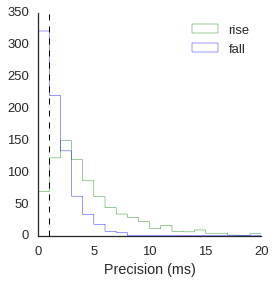

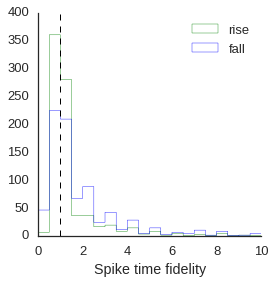

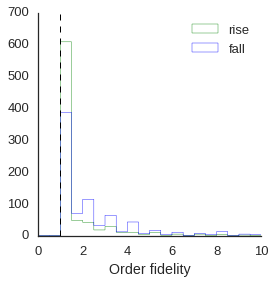

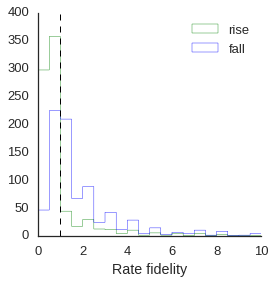

In [21]:
plt.figure(figsize=(4, 4))
plt.hist(box_precs_rise * 1000, color='g', label='rise', bins=20, range=(0, 20), histtype='step');
plt.hist(box_precs_fall * 1000, color='b', label='fall', bins=20, range=(0, 20), histtype='step');
plt.axvline(x=1, color='k', linewidth=1, linestyle='--')
plt.xlabel("Precision (ms)")
plt.legend()
sns.despine()

plt.figure(figsize=(4, 4))
plt.hist(box_lev_s_rise, color='g', label='rise', bins=20, range=(0, 10), histtype='step');
plt.hist(box_lev_s_fall, color='b', label='fall', bins=20, range=(0, 10), histtype='step');
plt.axvline(x=1, color='k', linewidth=1, linestyle='--')
plt.xlabel("Spike time fidelity")
plt.legend()
sns.despine()

plt.figure(figsize=(4, 4))
plt.hist(box_lev_o_rise, color='g', label='rise', bins=20, range=(0, 10), histtype='step');
plt.hist(box_lev_o_fall, color='b', label='fall', bins=20, range=(0, 10), histtype='step');
plt.axvline(x=1, color='k', linewidth=1, linestyle='--')
plt.xlabel("Order fidelity")
plt.legend()
sns.despine()

plt.figure(figsize=(4, 4))
plt.hist(box_lev_r_rise, color='g', label='rise', bins=20, range=(0, 10), histtype='step');
plt.hist(box_lev_r_fall, color='b', label='fall', bins=20, range=(0, 10), histtype='step');
plt.axvline(x=1, color='k', linewidth=1, linestyle='--')
plt.xlabel("Rate fidelity")
plt.legend()
sns.despine()